# 0.0 IMPORTS

In [2]:
import warnings
import seaborn                            as sns
import pandas                             as pd
import numpy                              as np   
import matplotlib.pyplot                  as plt
import plotly.express                     as px
import plotly.graph_objs                  as go
import cufflinks                          as cf

from plotly.offline import init_notebook_mode
from plotly.offline import plot
from plotly.offline import iplot

from matplotlib.ticker       import FuncFormatter

## 0.1 Helper Functions

In [3]:
init_notebook_mode(connected=True)
cf.go_offline()

In [4]:
warnings.filterwarnings('ignore')

## 0.2 Loading Data

In [5]:
dir_data = "../data/raw/microdados_censo_escolar_educacao_basica_2022/dados/"
file_data = "microdados_ed_basica_2022.csv"

# CSV
df_raw = pd.read_csv(dir_data + file_data, sep=';', encoding = "ISO-8859-1")

## 0.3 Loading Data Dictionary

In [6]:
dir_dict = "../data/raw/microdados_censo_escolar_educacao_basica_2022/Anexos/ANEXO I - Dicionаrio de Dados/"
file_dict = "dicionario_dados_educacao_basica.xlsx"

# EXCEL
df_dict = pd.read_excel(dir_dict + file_dict, skiprows=6, usecols="B:F")

In [7]:
# Filtering columns relevants by dictionary
df_private = (
    df_dict
    .loc[lambda x: (x['Nome da Variável'].notnull()) & (x['Categoria'].notnull())]
    .loc[lambda x: x['Categoria'].str.contains("Não aplicável para escolas privadas")]
    .reset_index(drop=True)
)

In [8]:
cols_remove = list(df_private['Nome da Variável'])

# 1.0 ETL

In [9]:
df1 = df_raw.copy()

## 1.1 Filtering Data Relevants

In [10]:
# TP_DEPENDENCIA igual a 4 se refere apenas a escolas particulares
# TP_SITUACAO_FUNCIONAMENTO igual a 1 se refere apenas a escolas em funcionamento

df1 = (
    df1
    .loc[lambda x: (x['TP_DEPENDENCIA'] == 4) & (x['TP_SITUACAO_FUNCIONAMENTO'] == 1)]
    .reset_index(drop=True)
)

## 1.2 Check NA

### 1.2.1 Create Data Frame with NA Percentage

In [11]:
df_isnull = pd.DataFrame(df1.isna().sum()).reset_index()
df_isnull.columns = ['attribute', 'value']
df_isnull['perc'] = round((df_isnull['value'] / df1.shape[0]) * 100, 2)

In [12]:
df_isnull[df_isnull['perc'] != 100].sort_values('perc', ascending=False).head(30)

,attribute,value,perc
264,TP_INDIGENA_LINGUA,45943,99.93
69,TP_OCUPACAO_GALPAO,45867,99.76
58,CO_ESCOLA_SEDE_VINCULADA,45850,99.72
59,CO_IES_OFERTANTE,45814,99.65
271,IN_RESERVA_PPI,42291,91.98
272,IN_RESERVA_RENDA,42291,91.98
273,IN_RESERVA_PUBLICA,42291,91.98
274,IN_RESERVA_PCD,42291,91.98
275,IN_RESERVA_OUTROS,42291,91.98
276,IN_RESERVA_NENHUMA,42291,91.98


### 1.2.2 Select Columns to Delete
**Column > 60% NA will be deleted**

In [13]:
cols_remove.extend(list(df_isnull[df_isnull['perc'] > 60]['attribute']))

## 1.4 Filtering Columns after Check NA

### 1.4.1 Columns deactivate

In [14]:
cols_deactivate = [
	"IN_CONVENIADA_PP",
	"TP_CONVENIO_PODER_PUBLICO",
	"IN_LOCAL_FUNC_SALAS_EMPRESA",
	"IN_LOCAL_FUNC_TEMPLO_IGREJA",
	"IN_LOCAL_FUNC_CASA_PROFESSOR",
	"IN_AGUA_FILTRADA",
	"IN_ENERGIA_GERADOR",
	"IN_ENERGIA_OUTROS",
	"IN_LIXO_JOGA_OUTRA_AREA",
	"IN_LIXO_OUTROS",
	"IN_LIXO_RECICLA",
	"IN_BANHEIRO_FORA_PREDIO",
	"IN_BANHEIRO_DENTRO_PREDIO",
	"IN_BERCARIO",
	"IN_DEPENDENCIAS_PNE",
	"IN_LAVANDERIA",
	"QT_SALAS_EXISTENTES",
	"IN_EQUIP_VIDEOCASSETE",
	"IN_EQUIP_RETROPROJETOR",
	"IN_EQUIP_FAX",
	"IN_EQUIP_FOTO",
	"QT_EQUIP_VIDEOCASSETE",
	"QT_EQUIP_PARABOLICA",
	"QT_EQUIP_COPIADORA",
	"QT_EQUIP_RETROPROJETOR",
	"QT_EQUIP_IMPRESSORA",
	"QT_EQUIP_IMPRESSORA_MULT",
	"QT_EQUIP_FAX",
	"QT_EQUIP_FOTO",
	"QT_COMP_ALUNO",
	"QT_COMPUTADOR",
	"QT_COMP_ADMINISTRATIVO",
	"QT_FUNCIONARIOS",
	"IN_MATERIAL_ESP_QUILOMBOLA",
	"IN_MATERIAL_ESP_INDIGENA",
	"IN_MATERIAL_ESP_NAO_UTILIZA",
	"IN_BRASIL_ALFABETIZADO",
	"IN_FINAL_SEMANA",
    "NU_ANO_CENSO"
]

### 1.4.2 Remove columns deactivate

In [15]:
cols_remove.extend(cols_deactivate)

In [16]:
df1 = df1.drop(cols_remove, axis=1)

## 1.5 Data Dimensions

In [17]:
print( 'From {} number of rows in Raw Data to {} rows filtered'.format(df_raw.shape[0], df1.shape[0]) )
print( 'From {} number of columns in Raw Data to {} columns filtered'.format(df_raw.shape[1], df1.shape[1]) )

From 224649 number of rows in Raw Data to 45977 rows filtered
From 385 number of columns in Raw Data to 312 columns filtered


# 2.0 Data Description

In [18]:
df2 = df1.copy()

In [23]:
matriculas_regiao = df2[[
    "NO_REGIAO",
    "QT_MAT_BAS",
    "QT_MAT_INF",
    "QT_MAT_INF_CRE",
    "QT_MAT_INF_PRE",
    "QT_MAT_FUND",
    "QT_MAT_FUND_AI",
    "QT_MAT_FUND_AF",
    "QT_MAT_MED",
    "QT_MAT_PROF",
    "QT_MAT_PROF_TEC",
    "QT_MAT_EJA",
    "QT_MAT_EJA_FUND",
    "QT_MAT_EJA_MED",
    "QT_MAT_ESP",
    "QT_MAT_ESP_CC",
    "QT_MAT_ESP_CE"
]].groupby("NO_REGIAO").mean().reset_index()

matriculas_regiao.set_index("NO_REGIAO").iplot(
    kind="scatter", xTitle="Regiões", yTitle="Quantidade de Matrículas"#, title="IDEB por ano"
)

## 2.1 Central Tendency

In [20]:
g = (
    df2.reindex(columns=[
        c for c in df2 if c.startswith("IN_")
    ] + ["QT_MAT_FUND"])
    .dropna(how="all", axis=1)
    .dropna(subset=["QT_MAT_FUND"])
)

res = list()
for c in g:
    if c != "QT_MAT_FUND":
        v0 = g.loc[lambda f: f[c] == 0, "QT_MAT_FUND"].mean()
        v1 = g.loc[lambda f: f[c] == 1, "QT_MAT_FUND"].mean()
        q0 = g.loc[lambda f: f[c] == 0, "QT_MAT_FUND"].shape[0]
        q1 = g.loc[lambda f: f[c] == 1, "QT_MAT_FUND"].shape[0]
        
        res.append((c, q0, q1, v0, v1, v1 - v0))
        
(
    pd.DataFrame(data=res, columns=["var", "q0", "q1", "v0", "v1", "degrau"])
    .assign(degrau_abs= lambda f: f["degrau"].abs())
    .loc[lambda f: f["q0"] / f[["q0", "q1"]].sum(axis=1) > 0.1]
    .loc[lambda f: f["q0"] / f[["q0", "q1"]].sum(axis=1) < 0.9]
    .sort_values(by="degrau_abs", ascending=False)
    .head(10)
)

,var,q0,q1,v0,v1,degrau,degrau_abs
165,IN_FUND_AF,26606,14405,26.334962,270.251649,243.916687,243.916687
166,IN_MED,32367,8644,62.381253,297.842318,235.461066,235.461066
54,IN_LABORATORIO_CIENCIAS,32394,8617,68.889794,274.112452,205.222658,205.222658
62,IN_QUADRA_ESPORTES_COBERTA,27957,13054,51.140788,242.370155,191.229367,191.229367
163,IN_FUND,16328,24683,0.000000,186.105538,186.105538,186.105538
98,IN_EQUIP_LOUSA_DIGITAL,36519,4492,92.130042,273.630009,181.499967,181.499967
80,IN_ACESSIBILIDADE_ELEVADOR,36609,4402,92.722910,272.410268,179.687358,179.687358
164,IN_FUND_AI,17338,23673,9.173549,187.326997,178.153448,178.153448
61,IN_QUADRA_ESPORTES,22828,18183,37.883433,205.072870,167.189438,167.189438
113,IN_PROF_BIBLIOTECARIO,30419,10592,70.994543,229.801737,158.807194,158.807194


In [18]:
selecao = (
    df2.assign(REGIAO= lambda f: f["CO_MUNICIPIO"].astype(str).str[0])
    .reindex(columns=[
        c for c in df2 if c.startswith("IN_")
    ] + ["REGIAO", "QT_MAT_MED"])
    .dropna(how="all", axis=1)
    .dropna(subset=["QT_MAT_MED"])
)

for i, g in selecao.groupby(["REGIAO"]):
    print("REGIAO", i[0])

    res = list()
    for c in g:
        if c != "QT_MAT_MED":
            v0 = g.loc[lambda f: f[c] == 0, "QT_MAT_MED"].mean()
            v1 = g.loc[lambda f: f[c] == 1, "QT_MAT_MED"].mean()
            q0 = g.loc[lambda f: f[c] == 0, "QT_MAT_MED"].shape[0]
            q1 = g.loc[lambda f: f[c] == 1, "QT_MAT_MED"].shape[0]

            res.append((c, q0, q1, v0, v1, v1 - v0))

    display(
        pd.DataFrame(data=res, columns=["var", "q0", "q1", "v0", "v1", "degrau"])
        .assign(degrau_abs= lambda f: f["degrau"].abs())
        .loc[lambda f: f[["q0", "q1"]].sum(axis=1) / g.shape[0] > 0.2]
        .loc[lambda f: f["q0"] / f[["q0", "q1"]].sum(axis=1) > 0.1]
        .loc[lambda f: f["q0"] / f[["q0", "q1"]].sum(axis=1) < 0.9]
        .sort_values(by="degrau_abs", ascending=False)
        .head(10)
    )

REGIAO 1


,var,q0,q1,v0,v1,degrau,degrau_abs
166,IN_MED,1283,456,0.000000,116.322368,116.322368,116.322368
98,IN_EQUIP_LOUSA_DIGITAL,1560,179,24.300641,84.547486,60.246845,60.246845
80,IN_ACESSIBILIDADE_ELEVADOR,1550,189,24.103226,82.978836,58.875610,58.875610
54,IN_LABORATORIO_CIENCIAS,1259,480,14.559968,72.316667,57.756698,57.756698
165,IN_FUND_AF,978,761,6.697342,61.094612,54.397271,54.397271
123,IN_PROF_MONITORES,1246,493,17.988764,62.127789,44.139025,44.139025
118,IN_PROF_PSICOLOGO,1346,393,20.644874,64.262087,43.617213,43.617213
62,IN_QUADRA_ESPORTES_COBERTA,995,744,11.844221,55.454301,43.610080,43.610080
125,IN_PROF_ASSIST_SOCIAL,1535,204,25.489251,68.220588,42.731337,42.731337
122,IN_PROF_SEGURANCA,1384,355,21.984104,63.709859,41.725755,41.725755


REGIAO 2


,var,q0,q1,v0,v1,degrau,degrau_abs
166,IN_MED,8462,2002,0.000000,107.387113,107.387113,107.387113
54,IN_LABORATORIO_CIENCIAS,8388,2076,6.962327,75.428227,68.465900,68.465900
123,IN_PROF_MONITORES,8644,1820,11.844054,61.873077,50.029023,50.029023
42,IN_AUDITORIO,8045,2419,9.517589,57.221993,47.704404,47.704404
62,IN_QUADRA_ESPORTES_COBERTA,7479,2985,7.056826,54.342044,47.285218,47.285218
122,IN_PROF_SEGURANCA,9020,1444,14.073614,60.972992,46.899377,46.899377
60,IN_PISCINA,9346,1118,16.133961,57.424866,41.290905,41.290905
118,IN_PROF_PSICOLOGO,7915,2549,10.906380,50.476658,39.570277,39.570277
55,IN_LABORATORIO_INFORMATICA,7556,2908,9.564849,49.077373,39.512524,39.512524
113,IN_PROF_BIBLIOTECARIO,7267,3197,8.493051,47.941820,39.448770,39.448770


REGIAO 3


,var,q0,q1,v0,v1,degrau,degrau_abs
166,IN_MED,15825,4442,0.000000,108.986493,108.986493,108.986493
80,IN_ACESSIBILIDADE_ELEVADOR,18187,2080,16.338758,89.887019,73.548261,73.548261
54,IN_LABORATORIO_CIENCIAS,16462,3805,11.925951,75.635480,63.709529,63.709529
165,IN_FUND_AF,13716,6551,5.672572,62.023050,56.350478,56.350478
113,IN_PROF_BIBLIOTECARIO,16170,4097,12.919419,67.173786,54.254367,54.254367
122,IN_PROF_SEGURANCA,17918,2349,17.845574,69.970626,52.125052,52.125052
42,IN_AUDITORIO,17233,3034,16.162479,67.762030,51.599551,51.599551
123,IN_PROF_MONITORES,16333,3934,13.958489,65.107778,51.149289,51.149289
98,IN_EQUIP_LOUSA_DIGITAL,17852,2415,17.905053,68.106418,50.201366,50.201366
129,IN_MATERIAL_PED_CIENTIFICO,14688,5579,10.936615,57.981896,47.045281,47.045281


REGIAO 4


,var,q0,q1,v0,v1,degrau,degrau_abs
166,IN_MED,4915,1049,0.000000,130.306006,130.306006,130.306006
54,IN_LABORATORIO_CIENCIAS,4422,1542,3.520579,78.549287,75.028708,75.028708
80,IN_ACESSIBILIDADE_ELEVADOR,4891,1073,10.027397,81.684063,71.656666,71.656666
165,IN_FUND_AF,4608,1356,7.257378,76.142330,68.884952,68.884952
113,IN_PROF_BIBLIOTECARIO,4277,1687,5.039747,68.248963,63.209215,63.209215
42,IN_AUDITORIO,4585,1379,8.605016,70.512690,61.907674,61.907674
123,IN_PROF_MONITORES,4642,1322,9.449591,70.216339,60.766748,60.766748
98,IN_EQUIP_LOUSA_DIGITAL,5301,663,16.572345,73.666667,57.094322,57.094322
62,IN_QUADRA_ESPORTES_COBERTA,4069,1895,6.313591,58.575726,52.262135,52.262135
129,IN_MATERIAL_PED_CIENTIFICO,4464,1500,11.340950,57.376667,46.035717,46.035717


REGIAO 5


,var,q0,q1,v0,v1,degrau,degrau_abs
166,IN_MED,1882,695,0.000000,118.899281,118.899281,118.899281
54,IN_LABORATORIO_CIENCIAS,1863,714,11.538379,85.628852,74.090473,74.090473
80,IN_ACESSIBILIDADE_ELEVADOR,2116,461,19.173440,91.245119,72.071679,72.071679
128,IN_MATERIAL_PED_INFANTIL,473,2104,78.680761,21.586977,-57.093784,57.093784
165,IN_FUND_AF,1495,1082,10.169231,62.321627,52.152396,52.152396
62,IN_QUADRA_ESPORTES_COBERTA,1417,1160,9.362738,59.800000,50.437262,50.437262
42,IN_AUDITORIO,1837,740,17.710942,67.702703,49.991761,49.991761
160,IN_INF,619,1958,66.258481,21.256895,-45.001587,45.001587
61,IN_QUADRA_ESPORTES,1067,1510,7.302718,49.564901,42.262183,42.262183
113,IN_PROF_BIBLIOTECARIO,1691,886,17.622117,59.634312,42.012194,42.012194


In [19]:
(
    df2.reindex(columns=[
        c for c in df2 if c.startswith("QT_")# or c.startswith("NU_")
    ])
    .select_dtypes(include=["int64", "float64"])
    .dropna(how="all", axis=1)
    .corr()
    .reindex(columns=["QT_MAT_BAS"])
    .sort_values(by=["QT_MAT_BAS"], ascending=False)
    .head(20)
)

,QT_MAT_BAS
QT_MAT_BAS,1.000000
QT_MAT_BAS_MASC,0.976751
QT_MAT_BAS_FEM,0.975655
QT_MAT_BAS_BRANCA,0.869068
QT_MAT_BAS_18_MAIS,0.748777
QT_MAT_PROF,0.721682
QT_MAT_PROF_TEC,0.721493
QT_TUR_BAS,0.719805
QT_MAT_BAS_EAD,0.707747
QT_MAT_BAS_D,0.683034


In [20]:
(
    df2.reindex(columns=[
        c for c in df2 if c.startswith("QT_") and not c.find("BAS") != -1
    ] + ["QT_MAT_BAS"])
    .select_dtypes(include=["int64", "float64"])
    .dropna(how="all", axis=1)
    .corr()
    .reindex(columns=["QT_MAT_BAS"])
    .sort_values(by=["QT_MAT_BAS"], ascending=False)
    .head(20)
)

,QT_MAT_BAS
QT_MAT_BAS,1.000000
QT_MAT_PROF,0.721682
QT_MAT_PROF_TEC,0.721493
QT_MAT_FUND,0.605317
QT_MAT_FUND_AF,0.586003
QT_DOC_ESP_CC,0.568242
QT_TUR_ESP_CC,0.560555
QT_MAT_FUND_AI,0.554364
QT_DOC_ESP,0.552779
QT_TUR_FUND,0.535303


# 3.0 Análise Exploratória de Dados (EDA)

In [18]:
df2 = df1.copy()

## 2.1 Matrículas por idade em cada região do Brasil

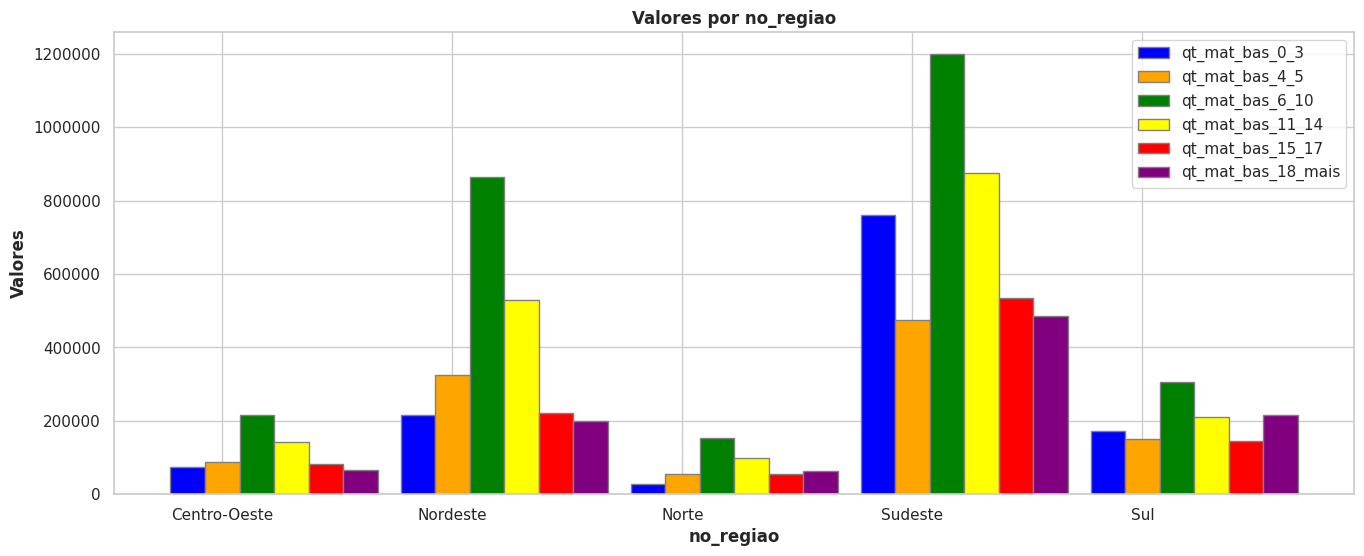

In [19]:
# Agrupando um novo dataframe para análise
hip_1 = df2[['no_regiao', 'qt_mat_bas_0_3', 'qt_mat_bas_4_5', 'qt_mat_bas_6_10', 'qt_mat_bas_11_14', 'qt_mat_bas_15_17', 'qt_mat_bas_18_mais']].groupby('no_regiao').sum().reset_index()

# Configuração do estilo Seaborn
sns.set(style="whitegrid")

# Plotando o gráfico
plt.figure(figsize=(16, 6))
bar_width = 0.15

# Ajuste das posições das barras para evitar sobreposições
r1 = range(len(hip_1['no_regiao']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

# Criando as barras
plt.bar(r1, hip_1['qt_mat_bas_0_3'], color='blue', width=bar_width, edgecolor='grey', label='qt_mat_bas_0_3')
plt.bar(r2, hip_1['qt_mat_bas_4_5'], color='orange', width=bar_width, edgecolor='grey', label='qt_mat_bas_4_5')
plt.bar(r3, hip_1['qt_mat_bas_6_10'], color='green', width=bar_width, edgecolor='grey', label='qt_mat_bas_6_10')
plt.bar(r4, hip_1['qt_mat_bas_11_14'], color='yellow', width=bar_width, edgecolor='grey', label='qt_mat_bas_11_14')
plt.bar(r5, hip_1['qt_mat_bas_15_17'], color='red', width=bar_width, edgecolor='grey', label='qt_mat_bas_15_17')
plt.bar(r6, hip_1['qt_mat_bas_18_mais'], color='purple', width=bar_width, edgecolor='grey', label='qt_mat_bas_18_mais')

# Adicionando rótulos e título
plt.xlabel('no_regiao', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(hip_1['no_regiao']))], hip_1['no_regiao'])
plt.ylabel('Valores', fontweight='bold')
plt.title('Valores por no_regiao', fontweight='bold')

# Configurando a notação científica no eixo y
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# Adicionando a legenda
plt.legend()

# Exibindo o gráfico
plt.show()

## 2.2 Matrículas por idade em cada UF do Brasil

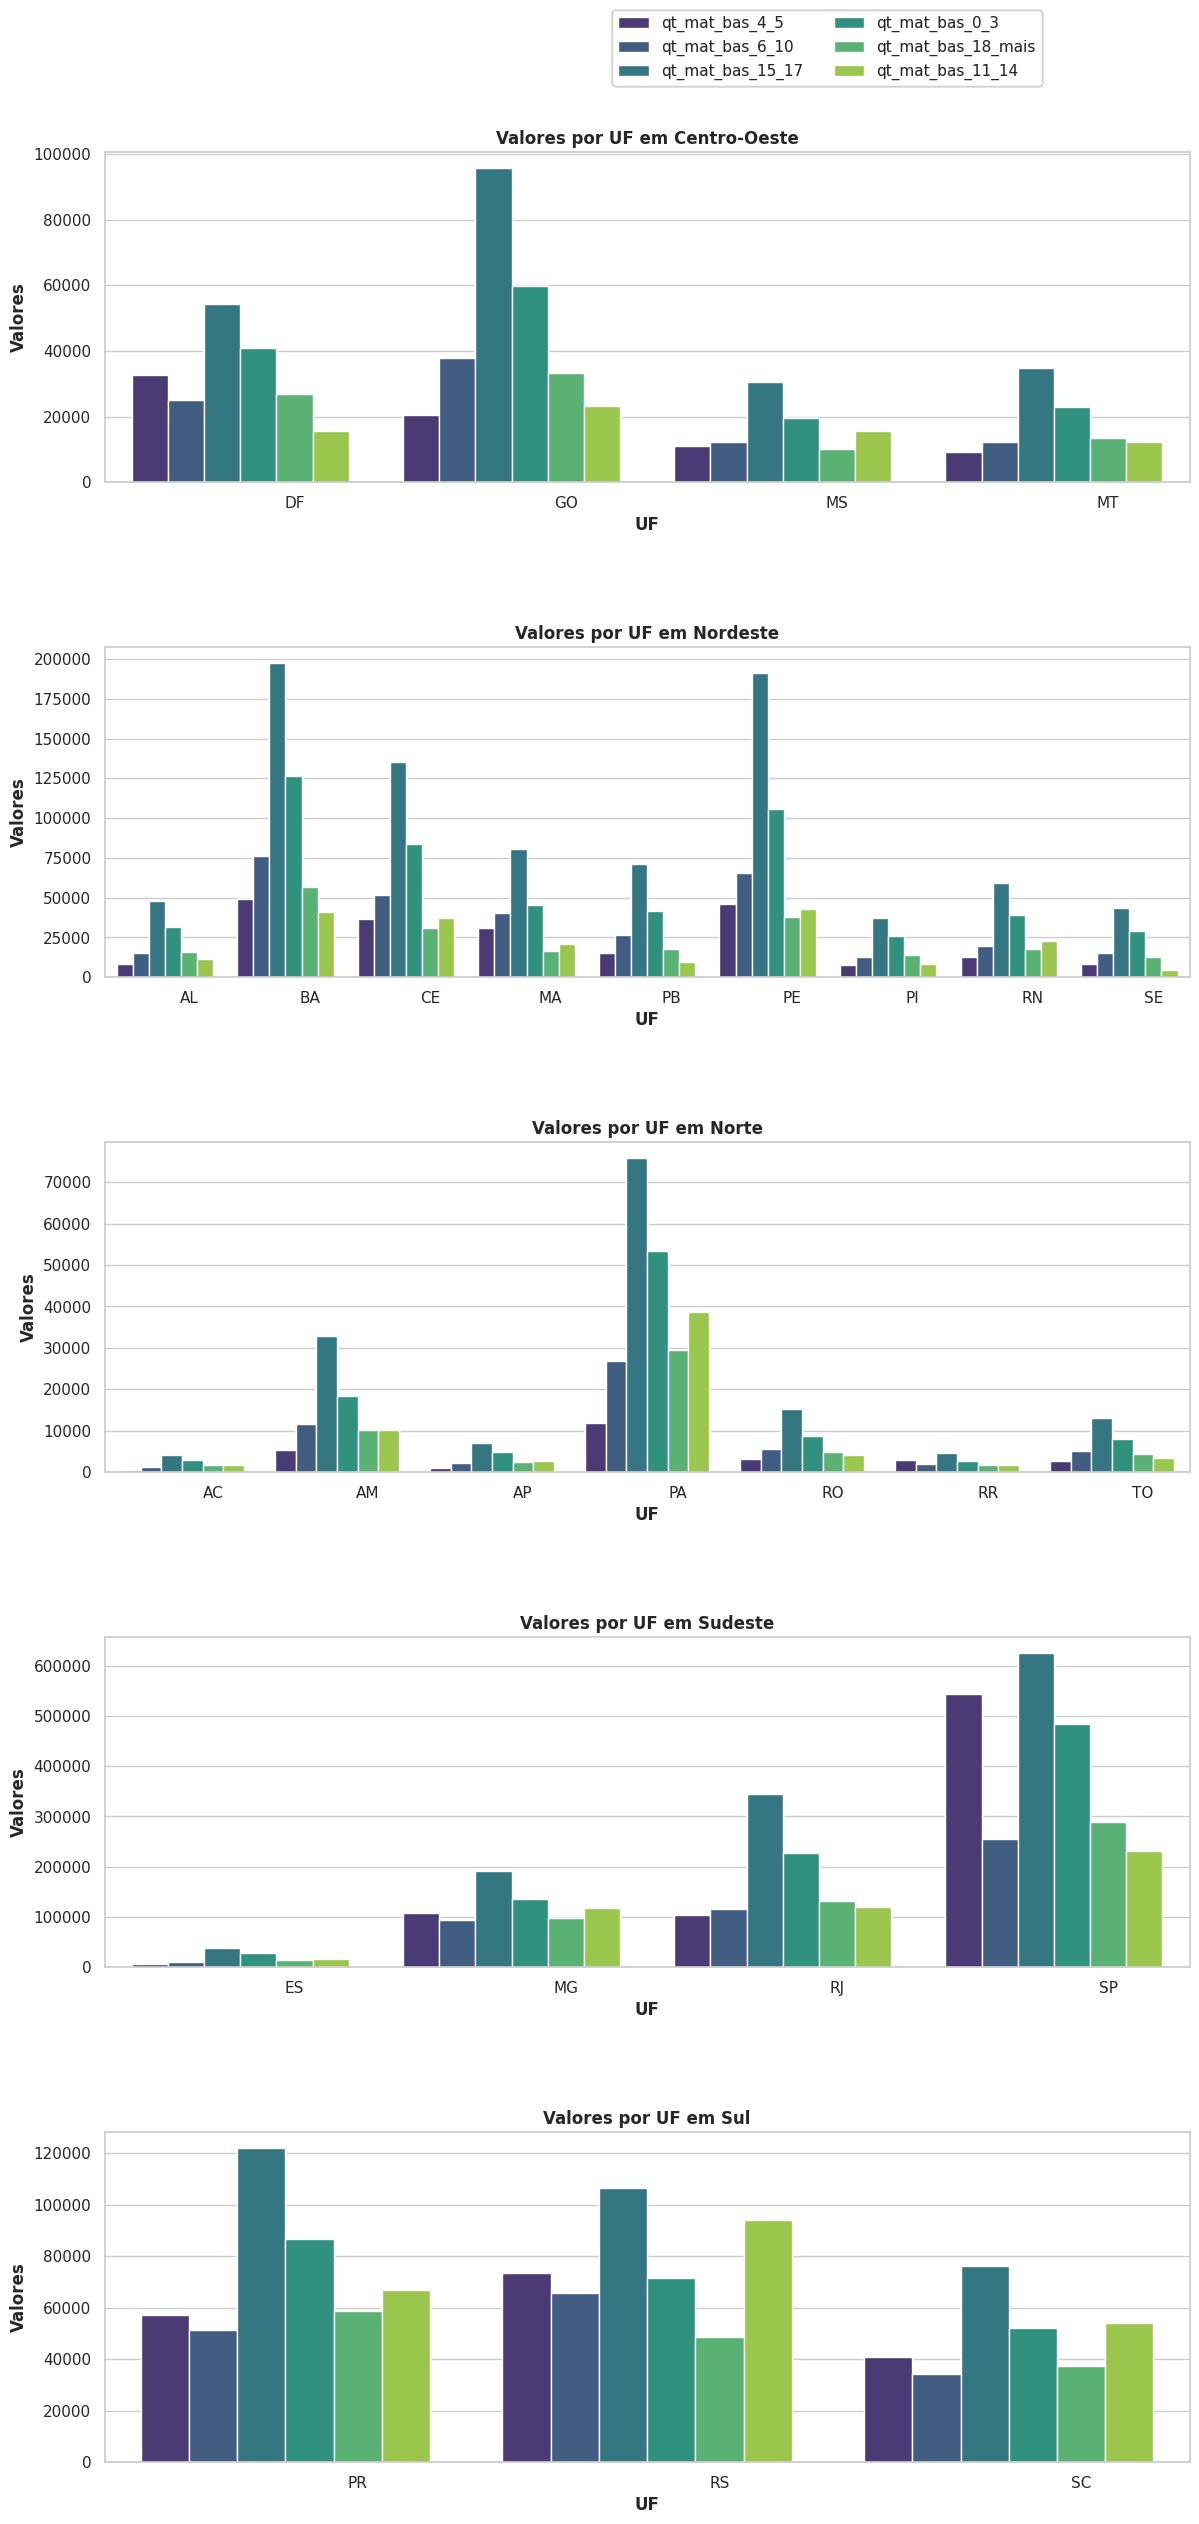

In [20]:
# Agrupando um novo dataframe para análise
hip_2 = df2[[
    'no_regiao', 'sg_uf', 'qt_mat_bas_0_3', 'qt_mat_bas_4_5', 'qt_mat_bas_6_10', 'qt_mat_bas_11_14', 'qt_mat_bas_15_17', 'qt_mat_bas_18_mais'
]].groupby(['no_regiao', 'sg_uf']).sum().reset_index()
hip_2_melt = pd.melt(hip_2, id_vars=['no_regiao', 'sg_uf'], var_name='Variavel', value_name='Valor')

# Configuração do estilo Seaborn
sns.set(style="whitegrid")

# Obter regiões únicas
regions = hip_2['no_regiao'].unique()

# Criar subplots para cada região
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(14, 6 * len(regions)))

# Iterar sobre as regiões e plotar gráficos
for i, region in enumerate(regions):
    region_data = hip_2_melt[hip_2_melt['no_regiao'] == region]
    
    # Ajustar o espaço entre os subplots
    plt.subplots_adjust(hspace=0.5)
    
    # Ajustar as posições das barras para evitar sobreposições
    bar_width = 0.2
    r_positions = [r + bar_width * j for j, r in enumerate(range(len(region_data['sg_uf'].unique())))]
    
    # Plotar as barras em cada subplot
    for k, uf in enumerate(region_data['sg_uf'].unique()):
        uf_data = region_data[region_data['sg_uf'] == uf]
        r = [x + bar_width * k for x in r_positions]
        sns.barplot(x='sg_uf', y='Valor', hue='Variavel', data=region_data, palette="viridis", ax=axes[i])
    
    # Adicionar rótulos e título a cada subplot
    axes[i].set_xlabel('UF', fontweight='bold')
    axes[i].set_xticks([r + bar_width for r in range(len(region_data['sg_uf'].unique()))])
    axes[i].set_xticklabels(region_data['sg_uf'].unique())
    axes[i].set_ylabel('Valores', fontweight='bold')
    axes[i].set_title(f'Valores por UF em {region}', fontweight='bold')
    axes[i].get_legend().remove()

    # add legend
    handles, labels = axes[i].get_legend_handles_labels()
    fig.legend(handles, set(labels), loc='upper right', ncol=2, bbox_to_anchor=(0.8, 0.93))

# Exibir os subplots
plt.show()

## 2.3 As 10 cidades com maiores quantidades de matrículas para os ensinos infantil, fundamental e médio

In [21]:
hip_3 = df2[[
    'sg_uf', 'no_municipio', 'qt_mat_bas', 'qt_mat_fund', 'qt_mat_med'
]].groupby(['sg_uf', 'no_municipio']).sum().reset_index()

# 10 maiores cidades por UF em cada faixa de idade de matriculas
top_10 = hip_3.sort_values(['qt_mat_bas', 'qt_mat_fund', 'qt_mat_med'], ascending=False).head(10)[['sg_uf', 'no_municipio', 'qt_mat_bas', 'qt_mat_fund', 'qt_mat_med']].reset_index()
top_10

,index,sg_uf,no_municipio,qt_mat_bas,qt_mat_fund,qt_mat_med
0,3298,SP,São Paulo,959522.0,353961.0,80885.0
1,2335,RJ,Rio de Janeiro,458396.0,233191.0,61683.0
2,565,DF,Brasília,195686.0,94264.0,26453.0
3,464,CE,Fortaleza,191670.0,110233.0,21226.0
4,918,MG,Belo Horizonte,178466.0,75760.0,21967.0
5,336,BA,Salvador,177838.0,89168.0,19687.0
6,2016,PR,Curitiba,133790.0,56741.0,18756.0
7,2633,RS,Porto Alegre,133290.0,45163.0,12602.0
8,1794,PE,Recife,126402.0,71008.0,13417.0
9,671,GO,Goiânia,103042.0,60589.0,15155.0


In [22]:
top_10_cidades = top_10['no_municipio'].unique()

## 2.4 Dessas 10 cidades, quais são os bairros com as maiores quantidades de matrículas?

In [23]:
hip_4 = df2[df2['no_municipio']=='São Paulo'].reset_index()

hip_4 = df2[[
    'sg_uf', 'no_municipio','no_bairro', 'qt_mat_bas', 'qt_mat_fund', 'qt_mat_med'
]].groupby(['no_municipio','sg_uf','no_bairro']).sum().reset_index()

In [24]:
hip_4_final = pd.DataFrame()

for i in top_10_cidades:
    aux = hip_4[hip_4['no_municipio']== i].groupby('no_bairro').sum().reset_index()
    hip_4_final = pd.concat([aux.sort_values(['qt_mat_bas', 'qt_mat_fund', 'qt_mat_med'], ascending=False).head(10).reset_index(drop=True), hip_4_final], axis=0)

hip_4_final

,no_bairro,no_municipio,sg_uf,qt_mat_bas,qt_mat_fund,qt_mat_med
0,SETOR BUENO,Goiânia,GO,12679.0,6668.0,3781.0
1,SETOR CENTRAL,Goiânia,GO,7206.0,2533.0,1229.0
2,SETOR MARISTA,Goiânia,GO,5390.0,2961.0,1393.0
3,JARDIM AMERICA,Goiânia,GO,4432.0,2952.0,542.0
4,JARDIM PLANALTO,Goiânia,GO,3196.0,2250.0,726.0
...,...,...,...,...,...,...
5,SAO MIGUEL PAULISTA,São Paulo,SP,7607.0,2607.0,694.0
6,VILA GOMES CARDIM,São Paulo,SP,7478.0,4645.0,1639.0
7,TATUAPE,São Paulo,SP,7333.0,4278.0,1140.0
8,SANTA CECILIA,São Paulo,SP,6886.0,850.0,183.0


In [25]:
# Agrupando um novo dataframe para análise
hip_4_final_melt = pd.melt(hip_4_final, id_vars=['no_bairro', 'no_municipio', 'sg_uf'], var_name='Variavel', value_name='Valor')
hip_4_final_melt

,no_bairro,no_municipio,sg_uf,Variavel,Valor
0,SETOR BUENO,Goiânia,GO,qt_mat_bas,12679.0
1,SETOR CENTRAL,Goiânia,GO,qt_mat_bas,7206.0
2,SETOR MARISTA,Goiânia,GO,qt_mat_bas,5390.0
3,JARDIM AMERICA,Goiânia,GO,qt_mat_bas,4432.0
4,JARDIM PLANALTO,Goiânia,GO,qt_mat_bas,3196.0
...,...,...,...,...,...
295,SAO MIGUEL PAULISTA,São Paulo,SP,qt_mat_med,694.0
296,VILA GOMES CARDIM,São Paulo,SP,qt_mat_med,1639.0
297,TATUAPE,São Paulo,SP,qt_mat_med,1140.0
298,SANTA CECILIA,São Paulo,SP,qt_mat_med,183.0


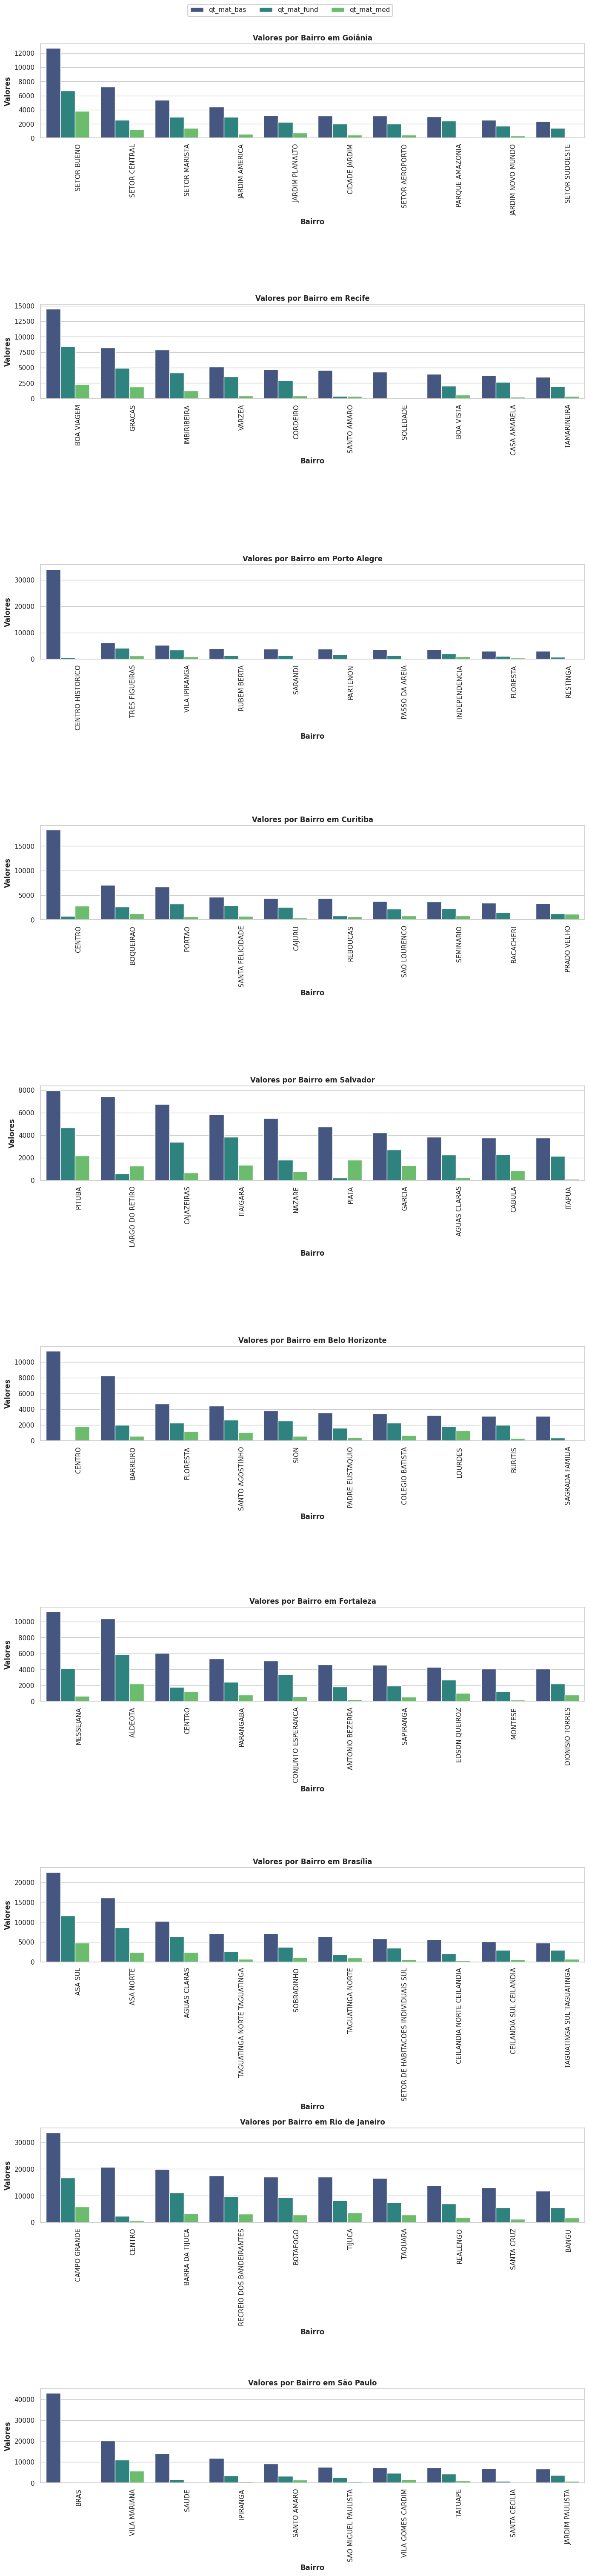

In [26]:
# Agrupando um novo dataframe para análise
hip_4_final_melt = pd.melt(hip_4_final, id_vars=['no_bairro', 'no_municipio', 'sg_uf'], var_name='Variavel', value_name='Valor')

# Configuração do estilo Seaborn
sns.set(style="whitegrid")

# Obter regiões únicas
regions = hip_4_final['no_municipio'].unique()

# Criar subplots para cada região
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(14, 6 * len(regions)))

# Iterar sobre as regiões e plotar gráficos
for i, region in enumerate(regions):
    region_data = hip_4_final_melt[hip_4_final_melt['no_municipio'] == region]
    
    # Ajustar o espaço entre os subplots
    plt.subplots_adjust(hspace=0.5)
    
    # Ajustar as posições das barras para evitar sobreposições
    bar_width = 0.2
    r_positions = [r + bar_width * j for j, r in enumerate(range(len(region_data['no_bairro'].unique())))]
    
    # Plotar as barras em cada subplot
    for k, uf in enumerate(region_data['no_bairro'].unique()):
        uf_data = region_data[region_data['no_bairro'] == uf]
        r = [x + bar_width * k for x in r_positions]
        sns.barplot(x='no_bairro', y='Valor', hue='Variavel', data=region_data, palette="viridis", ax=axes[i])
    
    # Adicionar rótulos e título a cada subplot
    axes[i].set_xlabel('Bairro', fontweight='bold')
    axes[i].set_xticks([r + bar_width for r in range(len(region_data['no_bairro'].unique()))])
    axes[i].set_xticklabels(region_data['no_bairro'].unique(), rotation=90)
    axes[i].set_ylabel('Valores', fontweight='bold')
    axes[i].set_title(f'Valores por Bairro em {region}', fontweight='bold')
    axes[i].get_legend().remove()

    # add legend
    handles, labels = axes[i].get_legend_handles_labels()
    fig.legend(handles, set(labels), loc='upper right', ncol=3, bbox_to_anchor=(0.67, 1.01))

plt.tight_layout()

# Exibir os subplots
plt.show()

**Próximos passos -> Integrar com API IBGE**
https://servicodados.ibge.gov.br/api/docs/malhas?versao=3#api-Malhas-microrregioesIdGet

## 2.5 Dentre esses bairros, quais são as principais escolas com mais matrículas por ensinos básico, fundamental e médio?

In [27]:
list_bairros = list(hip_4_final['no_bairro'].unique())
list_cidade = list(hip_4_final['no_municipio'].unique())
list_uf = list(hip_4_final['sg_uf'].unique())

hip_5 = (
    df2
    .loc[df2['no_bairro'].isin(list_bairros)]
    .loc[df2['no_municipio'].isin(list_cidade)]
    .loc[df2['sg_uf'].isin(list_uf)]
)

In [28]:
hip_5_final = hip_5[['co_entidade', 'no_entidade', 'no_bairro', 'no_municipio', 'sg_uf', 'qt_mat_bas', 'qt_mat_fund', 'qt_mat_med']].groupby(['no_entidade', 'no_bairro', 'no_municipio', 'sg_uf']).sum().reset_index()
top_escolas = []

for bairro in hip_5_final['no_bairro'].unique():

    qt_mat_bas = (
        hip_5_final
        .loc[lambda x: x['no_bairro'] == bairro]
        .sort_values('qt_mat_bas', ascending=False).head(10)
    )

    qt_mat_fund = (
        hip_5_final
        .loc[lambda x: x['no_bairro'] == bairro]
        .sort_values('qt_mat_fund', ascending=False).head(10)
    )

    qt_mat_med = (
        hip_5_final
        .loc[lambda x: x['no_bairro'] == bairro]
        .sort_values('qt_mat_med', ascending=False).head(10)
    )

    top_escolas_bairro = list(
        set(qt_mat_bas['co_entidade'].unique()) & 
        set(qt_mat_fund['co_entidade'].unique()) & 
        set(qt_mat_med['co_entidade'].unique())
    )
    
    top_escolas.extend(top_escolas_bairro)

# 3.0 Preparação da lista de escolas para prospecção

In [29]:
df3 = (
    df2
    .loc[df2['co_entidade'].isin(top_escolas)]
    .reset_index(drop=True)
)

In [30]:
df_final = df3[['no_entidade', 'ds_endereco', 'nu_endereco', 'no_bairro', 'co_cep', 'sg_uf', 'no_municipio', 'nu_ddd', 'nu_telefone']]
df_final['co_cep'] = df_final['co_cep'].astype(int)

In [34]:
df_final.head()

,no_entidade,ds_endereco,nu_endereco,no_bairro,co_cep,sg_uf,no_municipio,nu_ddd,nu_telefone
0,BATISTA SANTOS DUMONT COL,RUA DESEMBARGADOR LEITE ALBUQUERQUE,1056,ALDEOTA,60150150,CE,Fortaleza,85,40082300
1,SERAFICO NOSSA SENHORA DO BRASIL COLEGIO,AVENIDA FREI CIRILO,4454-A,MESSEJANA,60840285,CE,Fortaleza,85,32742112
2,NOSSA SENHORA DO CARMO COLEGIO,RUA ELVIRA PINHO,400,MONTESE,60421000,CE,Fortaleza,85,32250601
3,CECILIA COLEGIO SANTA,AVENIDA SENADOR VIRGILIO TAVORA,2000,ALDEOTA,60170251,CE,Fortaleza,85,30642377
4,COLEGIO CHRISTUS BARAO DE STUDART,RUA JOAO CARVALHO,630,ALDEOTA,60140140,CE,Fortaleza,85,32661800


# 4.0 Transformação para CSV

In [32]:
df_final.to_csv('../leads_top10_cidades.csv', index=False)